# Predicting Titanic survivors

## Imports

In [905]:
# Load the useful packages
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np # linear algebra
from numpy import median
import os
import re
import sklearn
import seaborn as sns # visualization
import matplotlib.pyplot as plt # plotting
%matplotlib inline
from IPython.display import display, display_html

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

#Common Model Algorithms
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import StackingClassifier

#Common Model Helpers
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import GridSearchCV   #Performing grid search
from sklearn.feature_selection import RFE, RFECV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer
from sklearn.impute import KNNImputer
from sklearn.neighbors import KNeighborsRegressor

sns.set(style="darkgrid")

## Load datasets

In [906]:
# Read train and test datasets and store the information in the appropriate dataframe variables
data_train = pd.read_csv('data/train.csv')
data_test = pd.read_csv('data/test.csv')

In [907]:
print("Train dataset shape:", data_train.shape)
print("Test dataset shape:", data_test.shape)

data_train_test = {"train": data_train, "test":data_test}
data_train.head()

Train dataset shape: (891, 12)
Test dataset shape: (418, 11)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [908]:
def get_full_data():
    return pd.concat(data_train_test.values())

## Exploring and preprocessing the data

| Feature   |      Definition      |  Key |
|----------|:-------------:|------:|
|PassengerId	    |Passenger identification number	| |
|Survived	    |Survival	|0 = No, 1 = Yes|
|Pclass	        |Ticket class | 	1 = 1st, 2 = 2nd, 3 = 3rd|
|Name	        |Passenger name | |
|Sex	        |Sex	| |
|Age	        |Age in years	| |
|SibSp	        |# of siblings / spouses aboard the Titanic	| |
|Parch	        |# of parents / children aboard the Titanic	| |
|Ticket	        |Ticket number	| |
|Fare	        |Passenger fare	| |
|Cabin	        |Cabin number	| |
|Embarked	    |Port of Embarkation | C = Cherbourg, Q = Queenstown, S = Southampton |

In [909]:
data_train.describe(include='all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Knight, Mr. Robert J",male,NaN,NaN,NaN,1601,NaN,C23 C25 C27,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


Count missing data in the train and test datasets (absolute and relative values)

In [910]:
def display_null_stats(data_train_test):
    for ds_name, ds in data_train_test.items():
        df_title =  f'{ds_name.capitalize()} Dataset'
        ds_count_nulls = ds.isnull().sum()
        ds_count_nulls = ds_count_nulls[ds_count_nulls.gt(0)]
        nulls_df = pd.DataFrame({"nulls":ds_count_nulls, "percent_nulls":ds_count_nulls/len(ds)})
        nulls_df = nulls_df.style.set_table_attributes("style='display:inline'").set_caption(df_title)
        display(nulls_df)

In [911]:
display_null_stats(data_train_test)

,nulls,percent_nulls
Age,177,0.198653
Cabin,687,0.771044
Embarked,2,0.002245


,nulls,percent_nulls
Age,86,0.205742
Fare,1,0.002392
Cabin,327,0.782297


Count and identify unique values in categorical features.

In [912]:
categorical_columns = data_train.select_dtypes(include=[object]).columns
for c in categorical_columns:
    unique_values = data_train[c].unique()
    num_unique_values = len(unique_values)
    print(f'Column {c} has {num_unique_values} unique values.\n{unique_values[:10]}')
    print('-'*50)

Column Name has 891 unique values.
['Braund, Mr. Owen Harris'
 'Cumings, Mrs. John Bradley (Florence Briggs Thayer)'
 'Heikkinen, Miss. Laina' 'Futrelle, Mrs. Jacques Heath (Lily May Peel)'
 'Allen, Mr. William Henry' 'Moran, Mr. James' 'McCarthy, Mr. Timothy J'
 'Palsson, Master. Gosta Leonard'
 'Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)'
 'Nasser, Mrs. Nicholas (Adele Achem)']
--------------------------------------------------
Column Sex has 2 unique values.
['male' 'female']
--------------------------------------------------
Column Ticket has 681 unique values.
['A/5 21171' 'PC 17599' 'STON/O2. 3101282' '113803' '373450' '330877'
 '17463' '349909' '347742' '237736']
--------------------------------------------------
Column Cabin has 148 unique values.
[nan 'C85' 'C123' 'E46' 'G6' 'C103' 'D56' 'A6' 'C23 C25 C27' 'B78']
--------------------------------------------------
Column Embarked has 4 unique values.
['S' 'C' 'Q' nan]
--------------------------------------------------


### **Data Visualization**

In [913]:
ft_to_palettes = {"Sex": "magma", "SibSp": "Blues_d", "Parch": "Greens_d", "Embarked": "Reds_d", "Pclass": "Purples_d"}

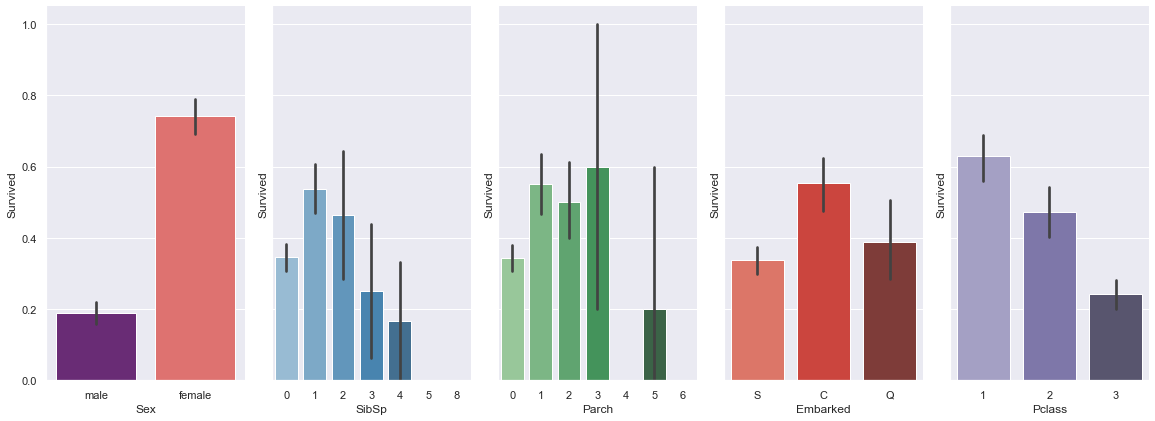

In [914]:
g = sns.PairGrid(data_train, y_vars="Survived",
                 x_vars=["Sex", "SibSp", "Parch", "Embarked", "Pclass"],
                 height=6, aspect=.55)

for x_var, ax in zip(g.x_vars, g.fig.axes):
    sns.barplot(x=x_var, y= g.y_vars[0], data=g.data, ax=ax, palette=ft_to_palettes[x_var])

The following five features Sex, SibSp, Parch, Embarked and Pclass seem to have an influential role in the survival likeliness.

Therefore those features are considered crucial for future model. Nevertheless, the final decision regarding the usage of a certain feature is only made after feature engineering (creation of new features) and further data analysis (for instance, correlation between features)

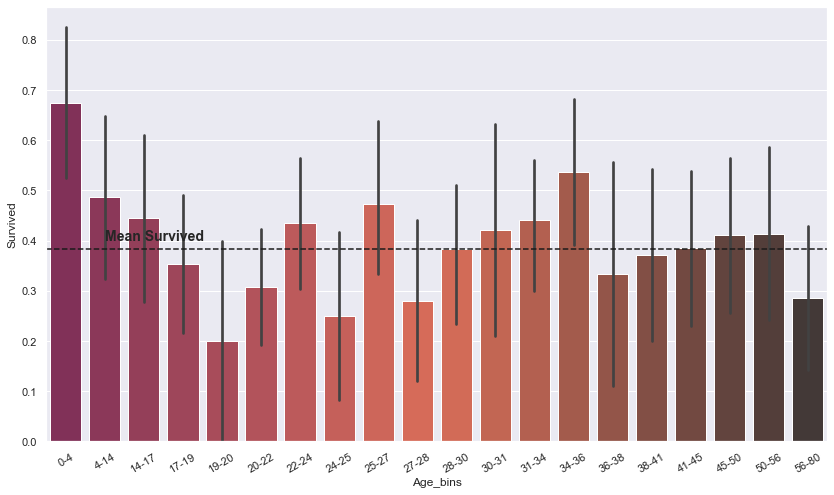

In [915]:
plt.figure(figsize=(14,8))
age_bins_df = pd.DataFrame({"Age_bins":pd.qcut(data_train['Age'], 20), "Survived": data_train.Survived})
g = sns.barplot(x='Age_bins', y='Survived', data=age_bins_df, palette="rocket_d")

x_tick_labels = [f'{int(x.left)}-{int(x.right)}'for x in age_bins_df["Age_bins"].cat.categories]
g.set_xticklabels(x_tick_labels, rotation=30)

g.axhline(data_train["Survived"].mean(), color='k', ls='--')
g.text(1,0.4, "Mean Survived", size=14, fontweight='bold');

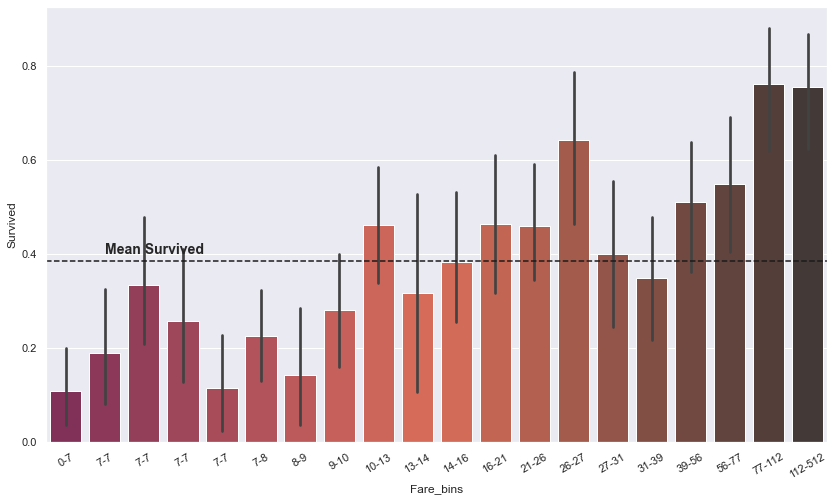

In [916]:
plt.figure(figsize=(14,8))
age_bins_df = pd.DataFrame({"Fare_bins":pd.qcut(data_train['Fare'], 20), "Survived": data_train.Survived})
g = sns.barplot(x='Fare_bins', y='Survived', data=age_bins_df, palette="rocket_d")

x_tick_labels = [f'{int(x.left)}-{int(x.right)}'for x in age_bins_df["Fare_bins"].cat.categories]
g.set_xticklabels(x_tick_labels, rotation=30)

g.axhline(data_train["Survived"].mean(), color='k', ls='--')
g.text(1,0.4, "Mean Survived", size=14, fontweight='bold');

### **Feature Engineering**

In [917]:
def get_ticket_number(ticket):
    # Gets the last number of the ticket string
    reversed_ticket = ticket[::-1]
    reversed_ticket_number = re.findall(r'(\d+)\b', reversed_ticket)
    if not reversed_ticket_number:
        return np.nan
    reversed_ticket_number = reversed_ticket_number[0]
    ticket_number = int(reversed_ticket_number[::-1])
    return ticket_number


for _, data in data_train_test.items():
    data['TicketNumber'] = data["Ticket"].apply(get_ticket_number)

In [918]:
# Create a new feature called CabinType which consists of the first letter present in Cabin. 
# Cabin feature has over 77% null entries
for _, data in data_train_test.items():
    data['CabinType'] = data.Cabin.str.get(0)

In [919]:
for _, data in data_train_test.items():
    data['Title'] = data.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

full_data = pd.concat([data_train, data_test])
pd.crosstab(full_data['Title'], full_data['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,4
Countess,1,0
Don,0,1
Dona,1,0
Dr,1,7
Jonkheer,0,1
Lady,1,0
Major,0,2


In [920]:
rare_titles = ['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona']
for _, data in data_train_test.items():
    # data['Title'] = data['Title'].replace(['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    rare_female_index = data[(data["Title"].isin(rare_titles)) & (data['Sex']=='female')].index
    data.at[rare_female_index, 'Title'] = 'Rare_Female'
    rare_male_index = data[(data["Title"].isin(rare_titles)) & (data['Sex']=='male')].index
    data.at[rare_male_index, 'Title'] = 'Rare_Male'
    data['Title'] = data['Title'].replace('Mlle', 'Miss')
    data['Title'] = data['Title'].replace('Ms', 'Miss')
    data['Title'] = data['Title'].replace('Mme', 'Mrs')

In [921]:
for _, data in data_train_test.items():
    data['SocialStatus'] = data.Fare/data.Pclass

    #Discrete variables
    data['FamilySize'] = data ['SibSp'] + data['Parch'] + 1
    data['IsAlone'] = data["FamilySize"].apply(lambda x: 1 if x==1 else 0)

In [922]:
display_null_stats(data_train_test)

,nulls,percent_nulls
Age,177,0.198653
Cabin,687,0.771044
Embarked,2,0.002245
TicketNumber,4,0.004489
CabinType,687,0.771044


,nulls,percent_nulls
Age,86,0.205742
Fare,1,0.002392
Cabin,327,0.782297
CabinType,327,0.782297
SocialStatus,1,0.002392


In [923]:
def has_missing_values(row):
    has_missing_values = row.isna().any()
    return 1 if has_missing_values else 0

In [924]:
for _, data in data_train_test.items():
    data["has_missing_values"] = data.apply(has_missing_values, axis=1)

Complete Data Visualization on the newly created features and perform a deeper analysis on the columns with missing values to get a sense on how to impute them.

Marked Features for further processing (Imputation of missing values): Age, Fare (and the corresponding SocialStatus), CabinType, Embarked and TicketNumber.

### **Further Data Visualization**

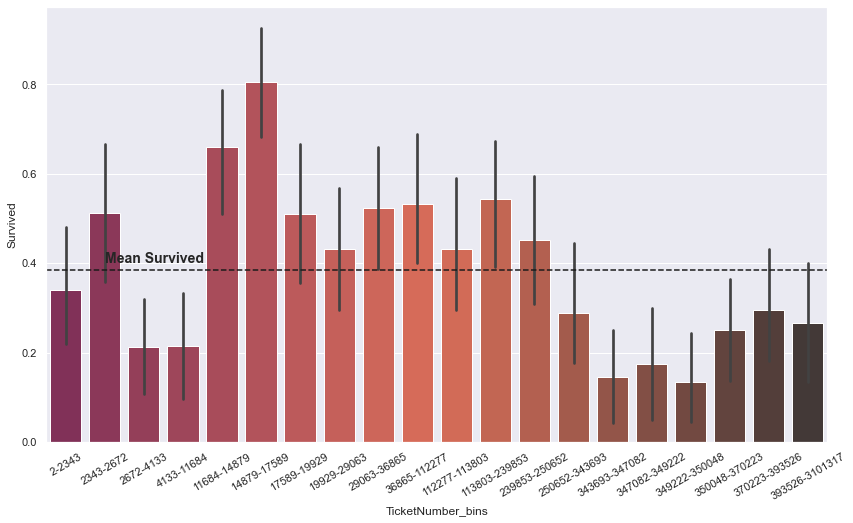

In [925]:
plt.figure(figsize=(14,8))
age_bins_df = pd.DataFrame({"TicketNumber_bins":pd.qcut(data_train['TicketNumber'], 20), "Survived": data_train.Survived})
g = sns.barplot(x='TicketNumber_bins', y='Survived', data=age_bins_df, palette="rocket_d")

x_tick_labels = [f'{int(x.left)}-{int(x.right)}'for x in age_bins_df["TicketNumber_bins"].cat.categories]
g.set_xticklabels(x_tick_labels, rotation=30)

g.axhline(data_train["Survived"].mean(), color='k', ls='--')
g.text(1,0.4, "Mean Survived", size=14, fontweight='bold');

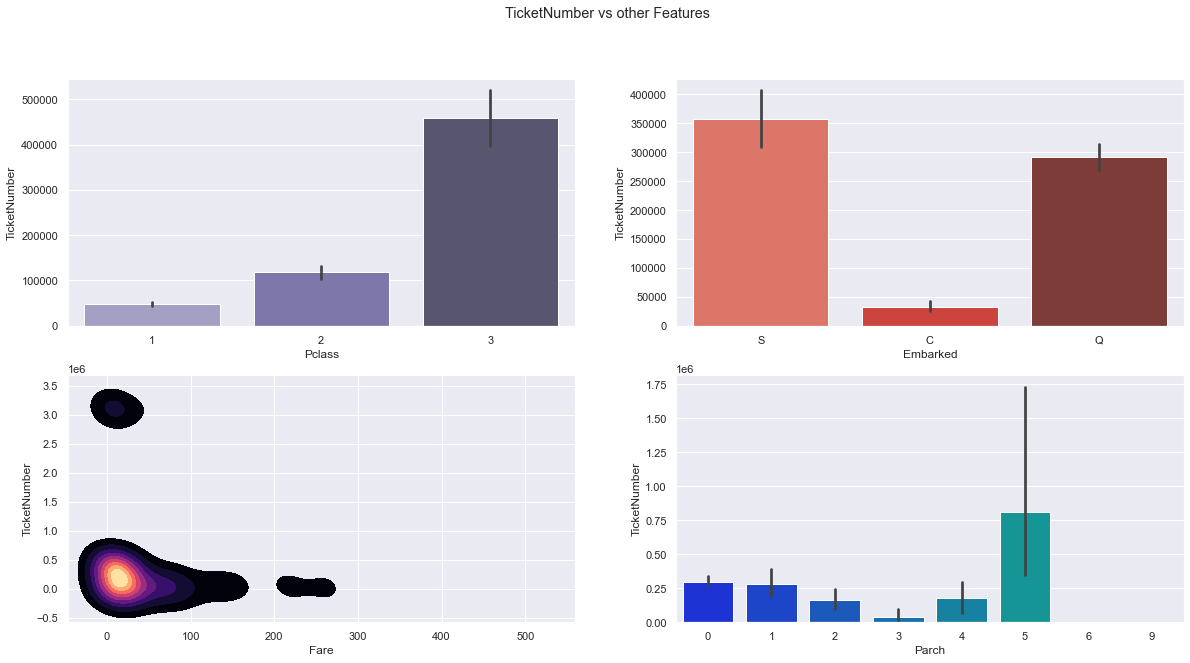

In [926]:
f, ax = plt.subplots(2, 2,figsize=(20,10))
plt.suptitle("TicketNumber vs other Features")
sns.barplot(y='TicketNumber', x='Pclass', data=get_full_data(), palette="Purples_d", ax = ax[0][0])
sns.barplot(y='TicketNumber', x='Embarked', data=get_full_data(), palette="Reds_d", ax = ax[0][1])
sns.kdeplot(y='TicketNumber', x='Fare', data=get_full_data(), palette="YlOrBr_d", ax = ax[1][0], cmap="magma", fill=True)
sns.barplot(y='TicketNumber', x='Parch', data=get_full_data(), palette="winter", ax = ax[1][1]);

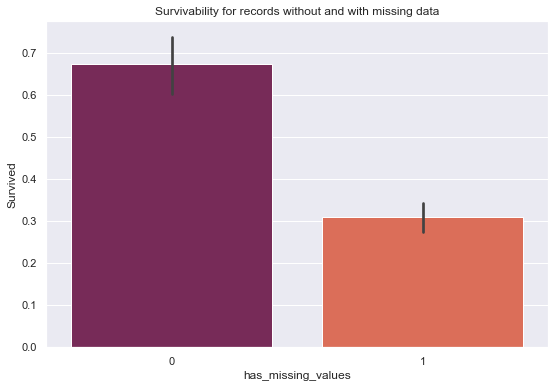

In [927]:
plt.figure(figsize=(9,6))
sns.barplot(x="has_missing_values", y='Survived', data=data_train, palette='rocket').set_title("Survivability for records without and with missing data");

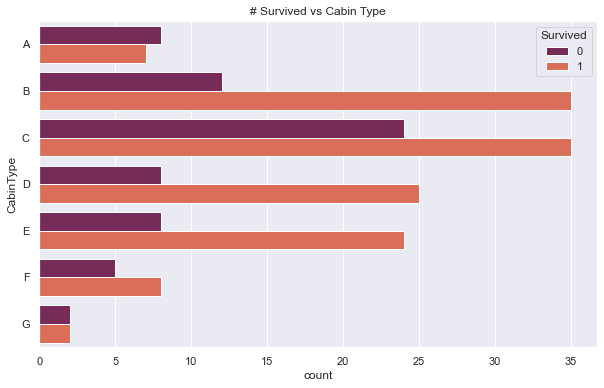

In [928]:
ordered_cabin_types = sorted(data['CabinType'].dropna().unique())
plt.figure(figsize=(10,6))
sns.countplot(y='CabinType', hue='Survived', data=data_train, palette="rocket", order=ordered_cabin_types).set_title("# Survived vs Cabin Type");

In [929]:
# Records with a valid CabinType value are more likely to belong to a person who actually survived.
# Assumption: some data was collected from interviewing Titanic survivors and therefore the CabinType of Survivors was more easily accessible.
print('Mean Survival Rate', round(data_train["Survived"].mean(),2))
print('Mean Survival Rate for records without CabinType', round(data_train[data_train.CabinType.isna()]["Survived"].mean(),2))
print('Mean Survival Rate for record with CabinType', round(data_train[~data_train.CabinType.isna()]["Survived"].mean(),2))

Mean Survival Rate 0.38
Mean Survival Rate for records without CabinType 0.3
Mean Survival Rate for record with CabinType 0.67


Even though it has a lot of missing values, the Cabin Type seems to have a decent influence in the target variable.

As can be found online the Titanic Titanic Data
| Pclass   |      Fare      |  Cabin Type |
|----------|:-------------:|------:|
|1st class	    |Highest fare	| A to E  |
|2nd class	    | | D to F |
|3rd class	        |Lowest fare | 	D to G |


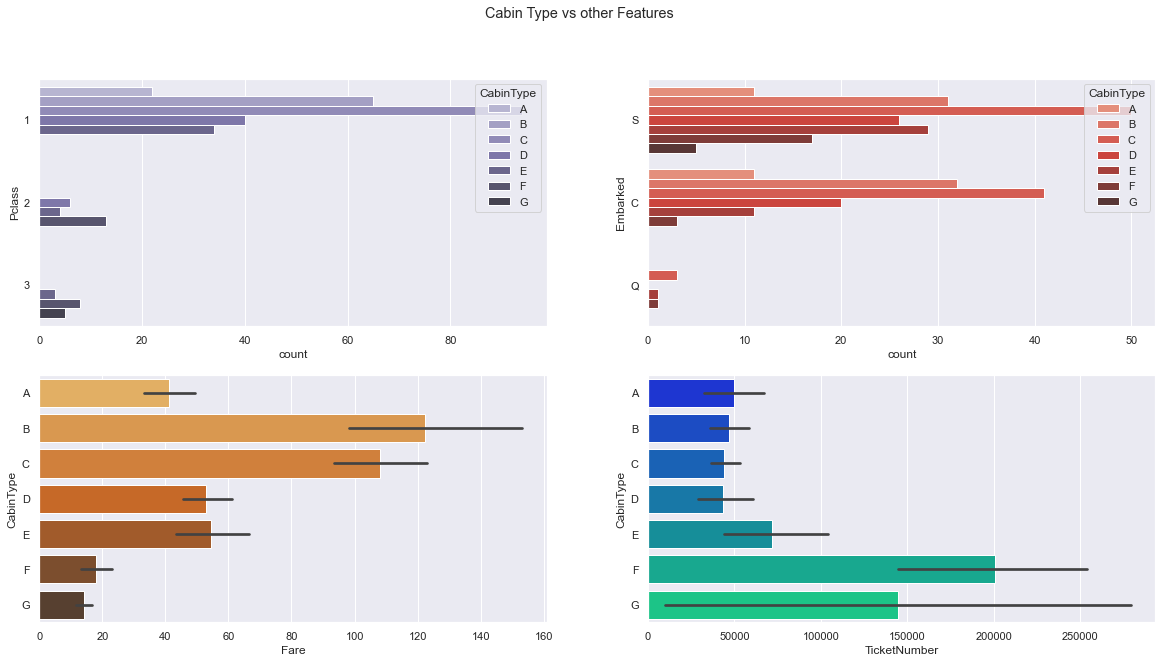

In [930]:
f, ax = plt.subplots(2, 2,figsize=(20,10))
plt.suptitle("Cabin Type vs other Features")
sns.countplot(y='Pclass', hue='CabinType', data=get_full_data(), palette="Purples_d", hue_order=ordered_cabin_types, ax = ax[0][0])
sns.countplot(y='Embarked', hue='CabinType', data=get_full_data(), palette="Reds_d", hue_order=ordered_cabin_types, ax = ax[0][1])
sns.barplot(y='CabinType', x='Fare', data=get_full_data(), palette="YlOrBr_d", order=ordered_cabin_types, ax = ax[1][0])
sns.barplot(y='CabinType', x='TicketNumber', data=get_full_data(), palette="winter", order=ordered_cabin_types, ax = ax[1][1]);

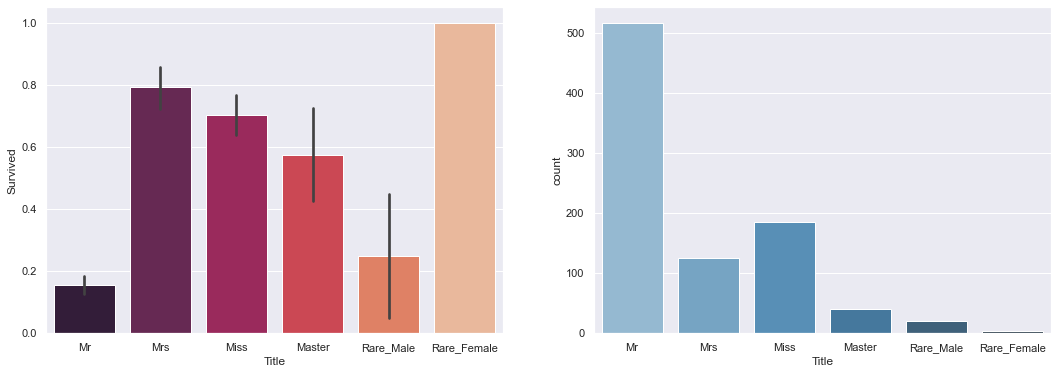

In [931]:
f, ax = plt.subplots(1, 2,figsize=(18,6))
sns.barplot(x='Title', y='Survived', data = data_train, palette="rocket",ax = ax[0]);
sns.countplot(x='Title', data = data_train, palette='Blues_d', ax = ax[1]);

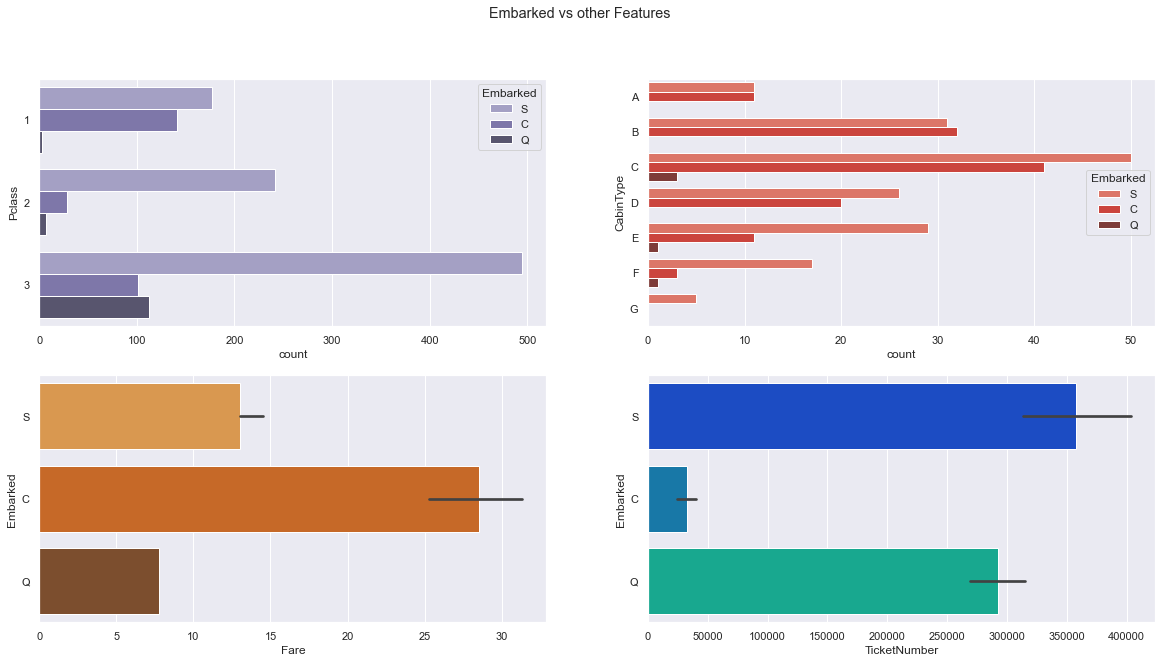

In [932]:
f, ax = plt.subplots(2, 2,figsize=(20,10))
plt.suptitle("Embarked vs other Features")
sns.countplot(y='Pclass', hue='Embarked', data=get_full_data(), palette="Purples_d", ax = ax[0][0])
sns.countplot(y='CabinType', hue='Embarked', data=get_full_data(), palette="Reds_d", order=ordered_cabin_types, ax = ax[0][1])
sns.barplot(y='Embarked', x='Fare', data=get_full_data(), palette="YlOrBr_d", ax = ax[1][0], estimator=median)
sns.barplot(y='Embarked', x='TicketNumber', data=get_full_data(), palette="winter", ax = ax[1][1]);

### Fare Plots
<a id='fare_plots'></a>

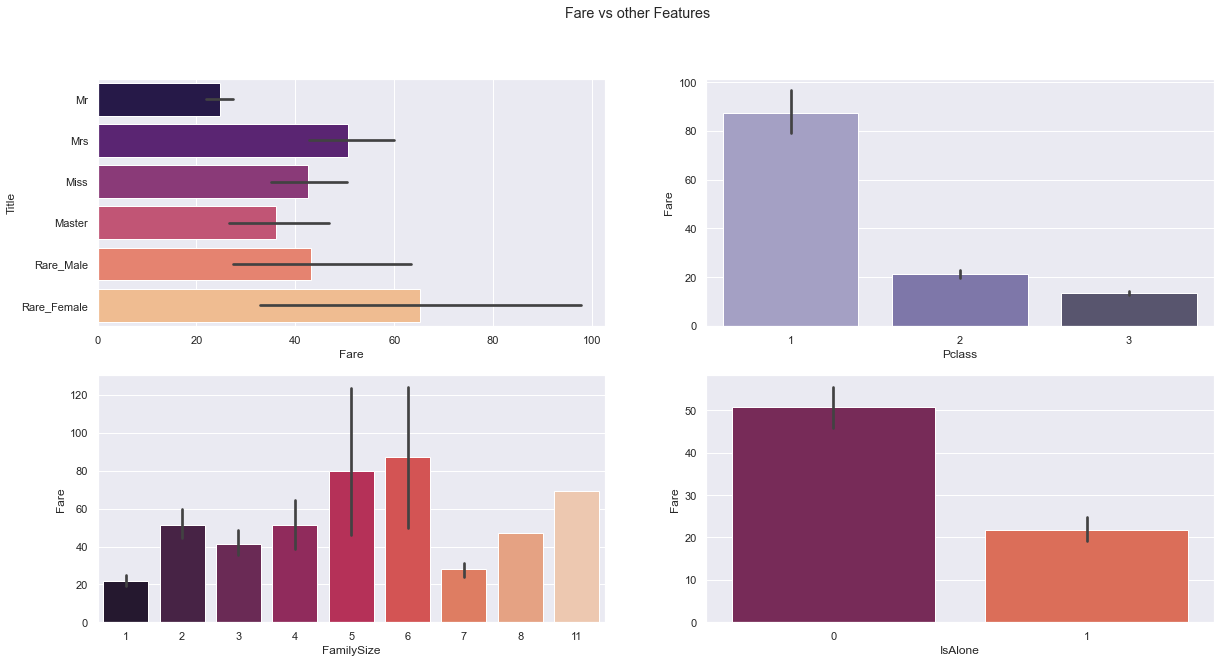

In [933]:
f, ax = plt.subplots(2, 2,figsize=(20,10))
plt.suptitle("Fare vs other Features")
sns.barplot(y='Title', x='Fare', data=get_full_data(), palette="magma", ax = ax[0][0])
sns.barplot(y='Fare', x='Pclass', data=get_full_data(), palette="Purples_d", ax = ax[0][1])
sns.barplot(y='Fare', x='FamilySize', data=get_full_data(), palette="rocket", ax = ax[1][0])
sns.barplot(y='Fare', x='IsAlone', data=get_full_data(), palette="rocket", ax = ax[1][1]);

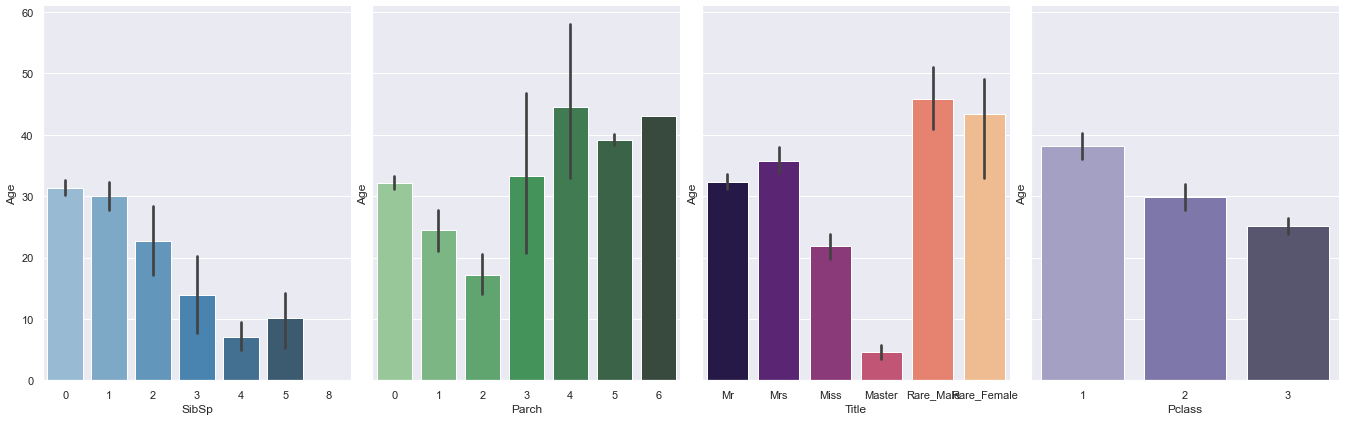

In [934]:
g = sns.PairGrid(data_train, y_vars="Age",
                 x_vars=["SibSp", "Parch", "Title", "Pclass"],
                 height=6, aspect=.8)

for x_var, ax in zip(g.x_vars, g.fig.axes):
    sns.barplot(x=x_var, y= g.y_vars[0], data=g.data, ax=ax, palette=ft_to_palettes.get(x_var, "magma"))

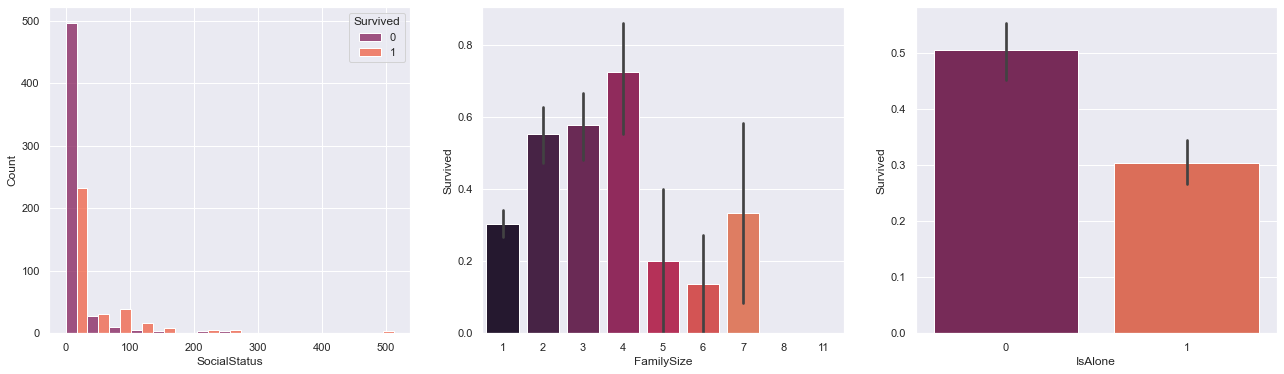

In [935]:
f, (ax_social, ax_fam, ax_alone) = plt.subplots(1, 3,figsize=(22,6))
sns.histplot(x='SocialStatus', hue='Survived', palette="rocket", data=data_train, ax = ax_social, multiple='dodge', bins=15)
sns.barplot(x='FamilySize', y='Survived', palette="rocket", data=data_train, ax = ax_fam)
sns.barplot(x='IsAlone', y='Survived', palette="rocket", data = data_train,  ax = ax_alone);

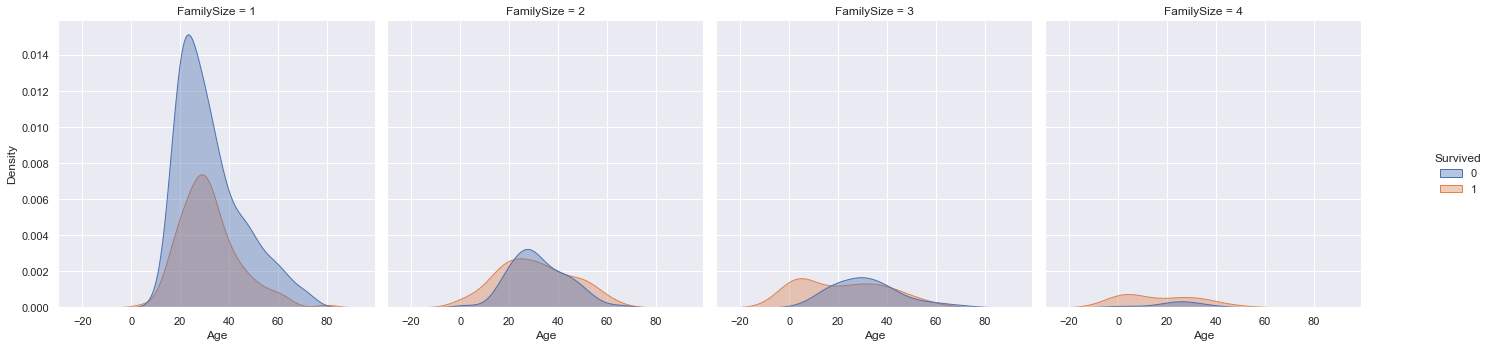

In [936]:
sns.displot(data_train[data_train.FamilySize < 5],
    x="Age",
    col="FamilySize", 
    hue="Survived",
    kind='kde',
    fill=True,
    facet_kws=dict(margin_titles=True),
    alpha=.4, linewidth=1);

### **Impute missing data**

In [937]:
for _, data in data_train_test.items():
    data["EmbarkedOrdinal"] = data["Embarked"].map({"S":0, "C":1, "Q":2})
    data["CabinTypeOrdinal"] = data["CabinType"].map({"A":0, "B":1, "C":2, "D":3, "E":4, "F":5, "G":6, "T":7})
    data["SexOrdinal"] = data["Sex"].map({"male":0, "female":1})
    data["TitleOrdinal"] = data["Title"].map({"Mr":0, "Mrs":1, "Miss":2, "Master":3, "Rare_Male":4, "Rare_Female":5})

In [938]:
drop_columns = ["PassengerId", "Name", "Sex", "Embarked", "CabinType", "Sex", "Ticket", "Cabin", "Title"]
for _, data in data_train_test.items():
    data.drop(columns=drop_columns, inplace=True)

Start by imputing Embarked and Fare features since there are only a few missing values.

In [939]:
missing_indexes = data_train[data_train["EmbarkedOrdinal"].isna()].index
data_train.loc[missing_indexes, :]

,Survived,Pclass,Age,SibSp,Parch,Fare,TicketNumber,SocialStatus,FamilySize,IsAlone,has_missing_values,EmbarkedOrdinal,CabinTypeOrdinal,SexOrdinal,TitleOrdinal
61,1,1,38.0,0,0,80.0,113572.0,80.0,1,1,1,NaN,1.0,1,2
829,1,1,62.0,0,0,80.0,113572.0,80.0,1,1,1,NaN,1.0,1,1


From the Embarked-related graphs plotted above, one can conclude that the missing values correspond to either 'C' or 'S'. There we can see that there aren't any records with CabinType=B and embarked=Q, and only a very small percentage of records with Pclass=1 have also embarked=Q.
For such reasons it is highly probable that the missing Embarked values doesn't correspond to Queenstown(Q).

The two records share the same Pclass and CabinType values. Taking a quick look at the data for such values:

In [940]:
get_full_data()[(get_full_data()["CabinTypeOrdinal"]==1) &
                (get_full_data()["Pclass"]==1)] \
                    .groupby("EmbarkedOrdinal").mean()

,Survived,Pclass,Age,SibSp,Parch,Fare,TicketNumber,SocialStatus,FamilySize,IsAlone,has_missing_values,CabinTypeOrdinal,SexOrdinal,TitleOrdinal
EmbarkedOrdinal,,,,,,,,,,,,,,
0.0,0.695652,1.0,34.500000,0.451613,0.580645,78.585352,62016.064516,78.585352,2.032258,0.451613,0.032258,1.0,0.516129,1.258065
1.0,0.772727,1.0,37.516129,0.468750,0.781250,167.461069,28406.125000,167.461069,2.250000,0.343750,0.031250,1.0,0.562500,1.031250


Comparing the missing records to the grouped median estimates displayed above, it is reasonable to suggest that the passengers embarked in Southampton (S).

In fact the values of the remaining features Parch, Fare, TicketNumber are much closer to the median of the group S.

However, such empirical conclusion is error-prone. A much more solid approach regards using KNN to find the similar records and impute the missing values.

In [941]:
def knn_impute(col, cols_to_drop, k_neighbors=5, round_to=0):
    full_data = get_full_data().reset_index(drop=True).drop(columns=cols_to_drop)

    col_index = full_data.columns.tolist().index(col)
    full_data = full_data.dropna(subset=full_data.columns.difference([col]))

    missing_indexes = full_data[full_data[col].isna()].index

    scaler = QuantileTransformer()
    df_scaled = pd.DataFrame(scaler.fit_transform(full_data), columns=full_data.columns, index=full_data.index)

    imputer = KNNImputer(n_neighbors=k_neighbors)
    df_imputed = pd.DataFrame(imputer.fit_transform(df_scaled), columns=full_data.columns, index=full_data.index)

    unscaled_col = scaler.inverse_transform(df_imputed)[:, col_index]
    df_imputed[col] = np.round(unscaled_col, round_to)

    max_index_train = data_train.index.max()
    # replace the missing values with the unscaled imputed values
    for ind in missing_indexes:
        # update train or test dataset depending on the index of the record
        if ind > max_index_train:
            data_test.at[ind-max_index_train-1, col] = df_imputed.at[ind, col]
        else:
            data_train.at[ind, col] = df_imputed.at[ind, col]

In [942]:
knn_impute("EmbarkedOrdinal", cols_to_drop=["Survived", "CabinTypeOrdinal", "has_missing_values"], k_neighbors=10, round_to=0)
data_train.EmbarkedOrdinal = data_train.EmbarkedOrdinal.astype(np.int64)

In [943]:
data_train.loc[missing_indexes, :]

,Survived,Pclass,Age,SibSp,Parch,Fare,TicketNumber,SocialStatus,FamilySize,IsAlone,has_missing_values,EmbarkedOrdinal,CabinTypeOrdinal,SexOrdinal,TitleOrdinal
61,1,1,38.0,0,0,80.0,113572.0,80.0,1,1,1,0,1.0,1,2
829,1,1,62.0,0,0,80.0,113572.0,80.0,1,1,1,0,1.0,1,1


[See Fare-related plots](#fare_plots)

Comparing the feature values, it is expected a relatively low Fare value.

In [944]:
knn_impute("Fare", cols_to_drop=["Survived", "CabinTypeOrdinal", "SocialStatus", "has_missing_values"], k_neighbors=10, round_to=2)
data_test['SocialStatus'] = data_test.Fare/data_test.Pclass

In [945]:
knn_impute("Age", cols_to_drop=["Survived", "CabinTypeOrdinal", "has_missing_values"], k_neighbors=10, round_to=2)

In [946]:
knn_impute("TicketNumber", cols_to_drop = ["Survived", "CabinTypeOrdinal", "has_missing_values"], k_neighbors=10, round_to=2)

### **Convert 'categorical' features to numeric values**

In [947]:
data_train = pd.concat([data_train,
                         pd.get_dummies(data_train["TitleOrdinal"], prefix='Title', drop_first=True),
                         pd.get_dummies(data_train["SexOrdinal"], prefix='Sex', drop_first=True),
                         pd.get_dummies(data_train["EmbarkedOrdinal"], prefix='Embarked', drop_first=True)],
                          axis=1)

In [948]:
data_test = pd.concat([data_test,
                         pd.get_dummies(data_test["TitleOrdinal"], prefix='Title', drop_first=True),
                         pd.get_dummies(data_test["SexOrdinal"], prefix='Sex', drop_first=True),
                         pd.get_dummies(data_test["EmbarkedOrdinal"], prefix='Embarked', drop_first=True)],
                          axis=1)

In [949]:
cols_to_drop = ["EmbarkedOrdinal", "SexOrdinal", "TitleOrdinal", "CabinTypeOrdinal"]
data_train.drop(columns=cols_to_drop, inplace=True)
data_test.drop(columns=cols_to_drop, inplace=True)

### **Prepare data for ML training**

In [950]:
X_train = data_train.drop("Survived", axis=1)
Y_train = data_train["Survived"]
X_test = data_test
print(f'X_train shape:{X_train.shape}, Y_train shape:{Y_train.shape}\nX_test shape:{X_test.shape}')

X_train shape:(891, 18), Y_train shape:(891,)
X_test shape:(418, 18)


In [952]:
df_scaler = QuantileTransformer()
X_train_test = pd.concat([X_train, X_test])
X_train_test_scaled = pd.DataFrame(df_scaler.fit_transform(X_train_test), columns=X_train_test.columns, index=X_train_test.index)

X_train_scaled, X_test_scaled= X_train_test_scaled.iloc[0:891], X_train_test_scaled.iloc[891:]

Base model performance for several families of Machine Learning Models

In [953]:
RANDOM_SEED = 7

In [954]:
models = [
    LogisticRegression,
    LinearDiscriminantAnalysis,
    SGDClassifier,
    KNeighborsClassifier,
    DecisionTreeClassifier, 
    RandomForestClassifier,
    xgb.XGBClassifier, 
    AdaBoostClassifier, 
    GradientBoostingClassifier,
    LGBMClassifier,
    MultinomialNB,
    GaussianNB,
    SVC]

data_results = []
for model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=RANDOM_SEED)
    cv_results = model_selection.cross_val_score(model(), X_train_scaled, Y_train, cv=kfold, scoring="accuracy")
    data_results.append({"name":model().__class__.__name__, "mean_acc":cv_results.mean(), "std_acc":cv_results.std()})

In [955]:
df_alg_results = pd.DataFrame(data_results)
df_alg_results.sort_values(by="mean_acc", ascending=False).head(50)

,name,mean_acc,std_acc
8,GradientBoostingClassifier,0.839526,0.036499
5,RandomForestClassifier,0.837278,0.036581
9,LGBMClassifier,0.830574,0.031238
12,SVC,0.828277,0.039602
1,LinearDiscriminantAnalysis,0.824919,0.036285
7,AdaBoostClassifier,0.822709,0.032621
0,LogisticRegression,0.822672,0.035452
6,XGBClassifier,0.820487,0.029238
3,KNeighborsClassifier,0.817079,0.032459
2,SGDClassifier,0.787828,0.046629


### **Feature selection**

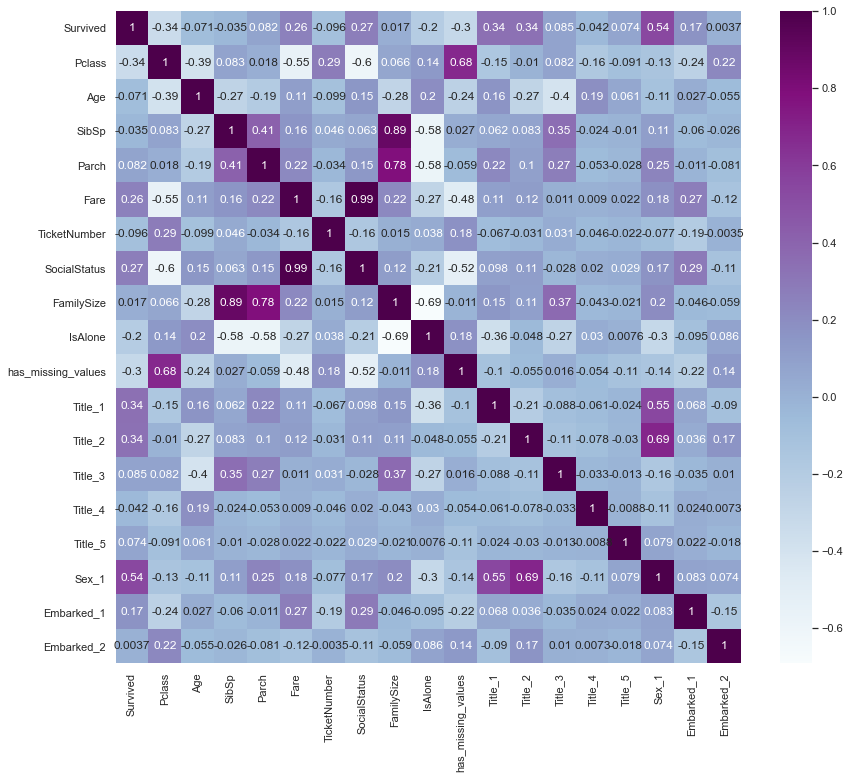

In [956]:
plt.figure(figsize=(14,12))
sns.heatmap(data_train.corr(),annot=True,cmap="BuPu");

The features *Fare* and *Social Status* have a very high correlation value (0.99). Therefore, one of the two should be dropped.

The feature *Fare* will be dropped, ince *Social Status* has a higher correlation with the target variable *Survived*.

In [957]:
X_train_scaled.drop(columns=['Fare'], inplace=True)
X_test_scaled.drop(columns=['Fare'], inplace=True)

In [960]:
selector = RFECV(RandomForestClassifier(), step=1, cv=10)
selector = selector.fit(X_train_scaled, Y_train)

In [961]:
features_mask = selector.support_
features_selected = []
for i in range(len(features_mask)):
    if features_mask[i]:
        features_selected.append(X_train_scaled.columns[i])
print(features_selected)

['Pclass', 'Age', 'SibSp', 'TicketNumber', 'SocialStatus', 'FamilySize', 'Title_1', 'Title_2', 'Sex_1']


In [964]:
best_algs = []

Random Forest hyperparameter tuning through GridSearch CV

In [965]:
# Choose the type of classifier. 
rf = RandomForestClassifier()

# Choose some parameter combinations to try
rf_parameters = {'n_estimators': [10, 20, 50], 
              'max_depth': [5, 6, 10], 
              'min_samples_split': [6, 10, 15],
              'min_samples_leaf': [6, 7, 8, 10, 15],
              'random_state': [RANDOM_SEED]
             }
# Type of scoring used to compare parameter combinations
acc_scorer = make_scorer(accuracy_score)

# Run the grid search
grid_obj_rf = GridSearchCV(rf, rf_parameters, scoring=acc_scorer, cv = 5, verbose=2, n_jobs=-1, return_train_score =True)
grid_obj_rf = grid_obj_rf.fit(X_rfe, Y_train)

# Set the clf to the best combination of parameters
best_rf = grid_obj_rf.best_estimator_

rf_index_best = grid_obj_rf.cv_results_['mean_test_score'].argmax()
rf_best_test_score = grid_obj_rf.cv_results_['mean_test_score'][rf_index_best]
rf_train_score = grid_obj_rf.cv_results_['mean_train_score'][rf_index_best]

best_algs.append({"model":best_rf, "test_score": rf_best_test_score})

Fitting 5 folds for each of 135 candidates, totalling 675 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 660 out of 675 | elapsed:   13.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 675 out of 675 | elapsed:   13.5s finished


In [966]:
# Choose the type of classifier. 
gbc = GradientBoostingClassifier()

# Choose some parameter combinations to try
gbc_parameters = {'n_estimators': [10, 20, 30, 50,100], 
              'learning_rate': [0.01, 0.05, 0.1], 
              'min_samples_split': [4, 5, 6, 10, 15],
              'min_samples_leaf': [6, 7, 8, 10, 15],
              'random_state': [RANDOM_SEED]
             }
# Type of scoring used to compare parameter combinations
acc_scorer = make_scorer(accuracy_score)

# Run the grid search
grid_obj_gbc = GridSearchCV(gbc, gbc_parameters, scoring=acc_scorer, cv = 5, verbose=2, n_jobs=-1, return_train_score =True)
grid_obj_gbc = grid_obj_gbc.fit(X_rfe, Y_train)

# Set the clf to the best combination of parameters
best_gbc = grid_obj_gbc.best_estimator_

gbc_index_best = grid_obj_gbc.cv_results_['mean_test_score'].argmax()
gbc_best_test_score = grid_obj_gbc.cv_results_['mean_test_score'][gbc_index_best]
gbc_train_score = grid_obj_gbc.cv_results_['mean_train_score'][gbc_index_best]

best_algs.append({"model":best_gbc, "test_score": gbc_best_test_score})

Fitting 5 folds for each of 375 candidates, totalling 1875 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 682 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 1248 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done 1860 out of 1875 | elapsed:   29.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 1875 out of 1875 | elapsed:   29.9s finished


XGB Hyperparameter tuning

In [968]:
xgb1 = xgb.XGBClassifier()

xgb_parameters = {'learning_rate': [0.0001, 0.001] ,
                  'n_estimators': [ 500, 1000, 1500, ],
                  'max_depth': [3, 4],
                  'min_child_weight': [0, 4],
                  'gamma': [ 0.0],
                  'colsample_bytree': [ 0.7],
                  'seed': [27],
                  'subsample': [0.7],
                  'scale_pos_weight': [1],
                  'reg_alpha': [0.00006],
                  'random_state': [RANDOM_SEED]
                }

# Run the grid search
grid_obj_xgb = GridSearchCV(xgb1, xgb_parameters, scoring=acc_scorer, cv = 3, verbose=2, n_jobs=-1, return_train_score =True)
grid_obj_xgb = grid_obj_xgb.fit(X_rfe, Y_train)

# Set the clf to the best combination of parameters
best_xgb = grid_obj_xgb.best_estimator_

xgb_index_best = grid_obj_xgb.cv_results_['mean_test_score'].argmax()
xgb_best_test_score = grid_obj_xgb.cv_results_['mean_test_score'][xgb_index_best]
xgb_train_score = grid_obj_xgb.cv_results_['mean_train_score'][xgb_index_best]

best_algs.append({"model":best_xgb, "test_score": xgb_best_test_score})

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:   13.9s finished


Select the best algorithm

In [976]:
best_alg = sorted(best_algs, key=lambda x: x['test_score'], reverse=True)[0]

In [977]:
best_alg

{'model': GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                            learning_rate=0.1, loss='deviance', max_depth=3,
                            max_features=None, max_leaf_nodes=None,
                            min_impurity_decrease=0.0, min_impurity_split=None,
                            min_samples_leaf=7, min_samples_split=15,
                            min_weight_fraction_leaf=0.0, n_estimators=100,
                            n_iter_no_change=None, presort='deprecated',
                            random_state=7, subsample=1.0, tol=0.0001,
                            validation_fraction=0.1, verbose=0,
                            warm_start=False),
 'test_score': 0.8507501098487227}

In [ ]:
best_alg = best_xgb if xgb_best_test_score > rf_best_test_score else best_rf

In [ ]:
best_alg = best_rf

In [ ]:
best_alg.fit(X_rfe, Y_train)
Y_pred = best_alg.predict(X_rfe_test)

In [ ]:
#best RF
submission = pd.DataFrame({'PassengerId': pd.read_csv('data/test.csv')["PassengerId"], 'Survived': Y_pred})
submission.to_csv('submission_best.csv',index=False)
submission.head()